# Dual pass copy

This code runs a prototype of the dual-pass algorithm for the copying framework in a toy problem.

### Data pre-processing

Create original dataset using the two spirals problem

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def two_spirals(n_samples, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_samples),np.ones(n_samples))))

Plot data distribution

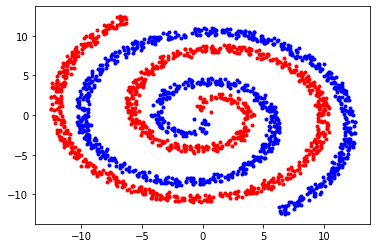

In [2]:
X,y=two_spirals(1000,noise = 1.)

plt.plot(X[y==0,0],X[y==0,1],'r.')
plt.plot(X[y==1,0],X[y==1,1],'b.')

Standardize and split to create training and test sets

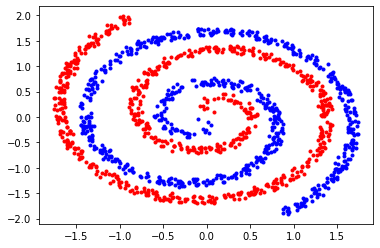

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size=test_size, random_state=42)

scaler = StandardScaler(copy=True)
scaler.fit(X_train)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

plt.plot(X_train[y_train==0,0],X_train[y_train==0,1],'r.')
plt.plot(X_train[y_train==1,0],X_train[y_train==1,1],'b.')

### Original model

Train and evaluate a gaussian kernel SVM

In [4]:
from sklearn.svm import SVC

original = SVC(gamma=10)
original.fit(X_train,y_train)

SVC(gamma=10)

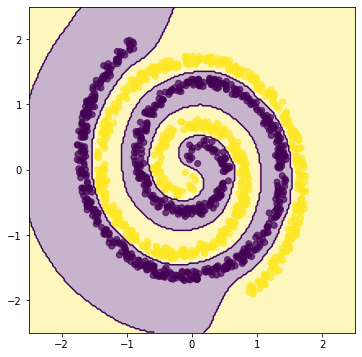

In [5]:
xx,yy = np.meshgrid(np.linspace(-2.5,2.5,200),np.linspace(-2.5,2.5,200))
viz=np.c_[xx.ravel(),yy.ravel()]

z = original.predict(viz)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  alpha=0.7)
plt.imshow(z.reshape((200,200)), origin='lower', extent=(-2.5,2.5,-2.5,2.5),alpha=0.3, vmin=0, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[0.5])

plt.gcf().set_size_inches((6,6))

In [6]:
y_test_pred = original.predict(X_test)
print('AO: {}'.format(np.average(np.where(y_test_pred==y_test,1.,0.))))

AO: 1.0


The model above is used as a baseline for the upcoming trials. The aim is to train a new model, the copy, that replicates the learned decision behavior. To do so, no access is allowed to the original data points. Instead, a synthetic set of new data instances should be created in the original data domain. Equivalently, access to the trained model is limited to a hard membership query interface.

### Dual-pass copy

In this framework, the copy learns incrementally- At each step, a new set of synthetic data points is generated and fed to the copy model. The model is updated and the errors are identified and save to a budget. In every subseqeunt operation the previous errors are included once again in the training set to ensure a better fit in these areas.

#### Full memory

We use a fixed budget. Errors are added to the budget and never removed. The process stops once the budget is full.

In [7]:
import tensorflow as tf

# This model has been tested against the original training data
# Check the notebook network_training PyTorch-Tensorflow for reference
copy_model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(64, input_shape=(2,), activation='relu', kernel_initializer='he_normal'),
          tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),  
          tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
          tf.keras.layers.Dense(2, activation='softmax')
        ])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

copy_model.compile(optimizer=opt, 
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [8]:
d = 2 # dimensions
max_exploration = 100 # budget size
n_epochs = 1000 # number of epochs for each training step
n_exploration = max_exploration # exploration size

# Create empty budget of points
X_budget = np.empty((0, d))
y_budget = np.empty((0), dtype=int)

# One-hot the test data points
y_test_oh_mamma = tf.one_hot(y_test, 2)
y_test = np.argmax(y_test_oh_mamma, axis=1)

# Initialize error array
acc = []
n_errors = []

Iteration: 1


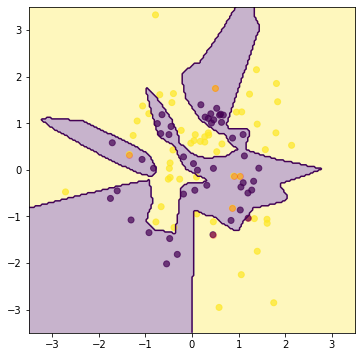

Iteration: 2


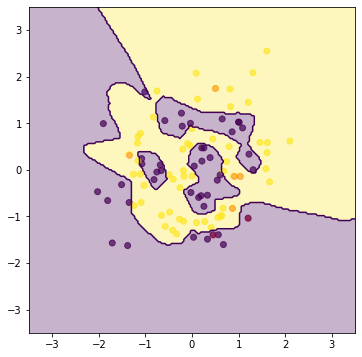

Iteration: 3


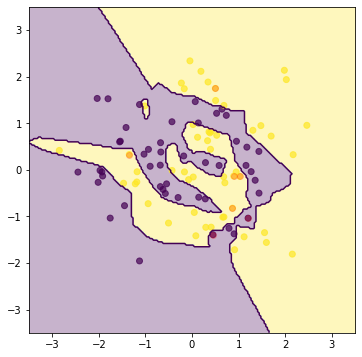

Iteration: 4


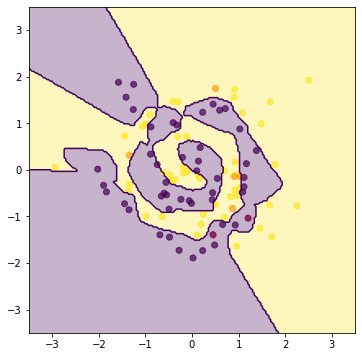

Iteration: 5


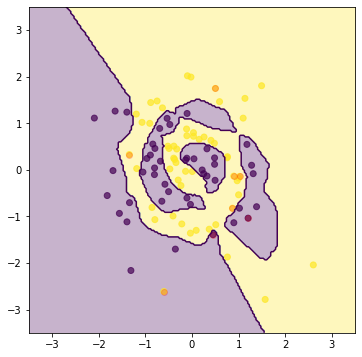

Iteration: 6


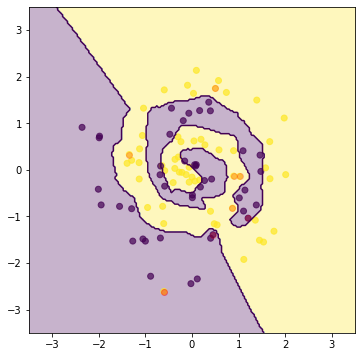

Iteration: 7


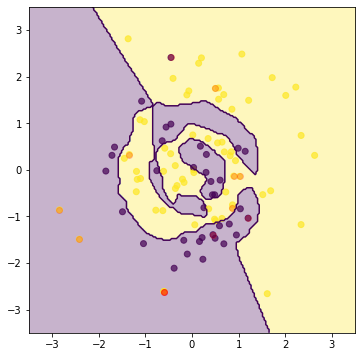

Iteration: 8


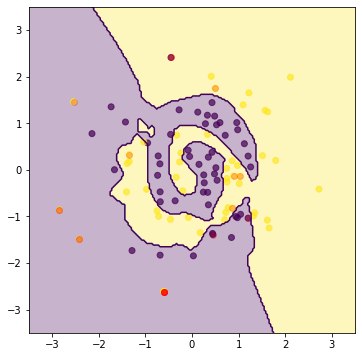

Iteration: 9


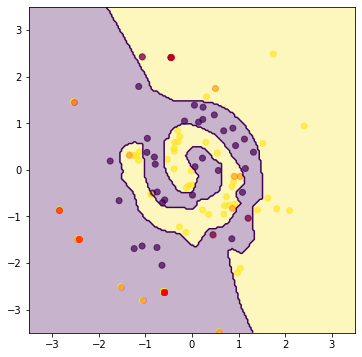

Iteration: 10


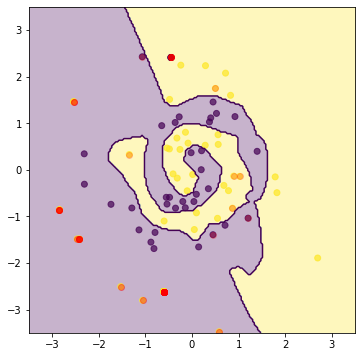

Iteration: 11


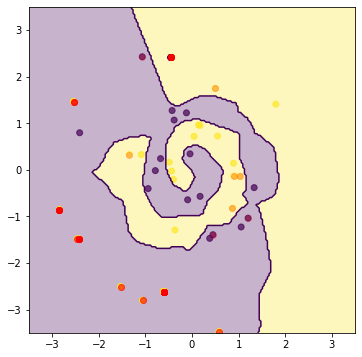

In [9]:
t = 1

while n_exploration > 0:
    
    print('Iteration: {}'.format(t))

    # Generate new points and label them
    X_new = np.random.multivariate_normal(np.zeros((d,)), np.eye(d,d), size = n_exploration)
    y_new = original.predict(X_new)
    y_new_oh_mamma = tf.one_hot(y_new, 2)
    y_new = np.argmax(y_new_oh_mamma, axis=1)
    
    # Update synthetic trainign set with new points
    X_train_ = np.vstack((X_budget, X_new))
    y_train_ = np.append(y_budget, y_new)
    
    # Update copy
    copy_model.fit(X_train_, tf.one_hot(y_train_, 2), epochs=n_epochs, batch_size=32, verbose=0)
    
    # Identify errors
    y_pred_ = np.argmax(copy_model.predict(X_train_), axis=1)
    X_errors = X_train_[y_pred_!=y_train_,:]
    y_errors = y_train_[y_pred_!=y_train_]

    n_errors.append(len(y_errors))
    
    # Add errors to the budget
    X_budget = np.vstack((X_budget, X_errors))
    y_budget = np.append(y_budget, y_errors)
    
    # Update exploration size
    n_exploration = max_exploration - len(y_budget)
    
    # Plot model
    xx,yy = np.meshgrid(np.linspace(-3.5,3.5,200),np.linspace(-3.5,3.5,200))
    viz=np.c_[xx.ravel(),yy.ravel()]

    z = np.argmax(copy_model.predict(viz), axis=1)
    
    plt.scatter(X_train_[:, 0], X_train_[:, 1], c=y_train_,  alpha=0.7)
    plt.scatter(X_budget[:, 0], X_budget[:, 1], c='red',  alpha=0.2)
   
    plt.imshow(z.reshape((200,200)), origin='lower', extent=(-3.5,3.5,-3.5,3.5),alpha=0.3, vmin=0, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)),[0.5])

    plt.gcf().set_size_inches((6,6))
    
    plt.show()
    
    # Compute copy accuracy on original test data
    acc.append(copy_model.evaluate(X_test, tf.one_hot(y_test, 2), verbose=0)[1])
    
    t += 1

When updating the net at each iteration, iti is important to ensure that the model doesn't forget the learnings from previous iterations. We can ensure that this information is ketp in memory by setting an adaptive learning rate (not by epoch, but by iteration). This way, we can force the learnign rate to be higher at the beginning, when the net is learning the general behavior of the original model, and smaller at the end, when it is focusing on the details.

In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

# This model has been tested against the original training data
# Check the notebook network_training PyTorch-Tensorflow for reference
copy_model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(64, input_shape=(2,), activation='relu', kernel_initializer='he_normal'),
          tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),  
          tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
          tf.keras.layers.Dense(2, activation='softmax')
        ])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

copy_model.compile(optimizer=opt, 
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

def lr_time_based_decay(epoch, lr):
        return decay

t = 1
initial_learning_rate = 0.005
max_iter = 1
decay = initial_learning_rate

In [11]:
d = 2 # dimensions
max_exploration = 100 # budget size
n_epochs = 1000 # number of epochs for each training step
n_exploration = max_exploration # exploration size

# Create empty budget of points
X_budget = np.empty((0, d))
y_budget = np.empty((0), dtype=int)

# One-hot the test data points
y_test_oh_mamma = tf.one_hot(y_test, 2)
y_test = np.argmax(y_test_oh_mamma, axis=1)

# Initialize error array
acc = []
n_errors = []

Iteration: 1
0.005


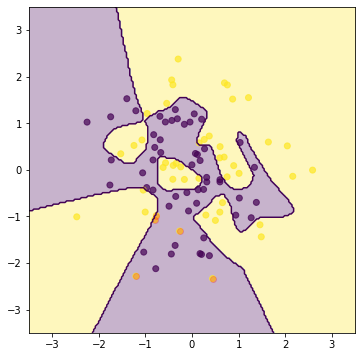

Iteration: 2
0.0033333333333333335


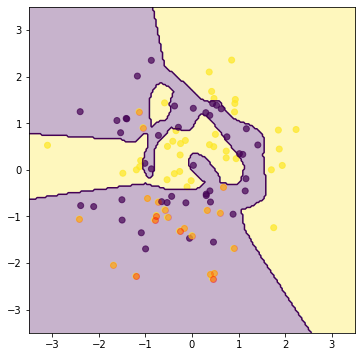

Iteration: 3
0.0025


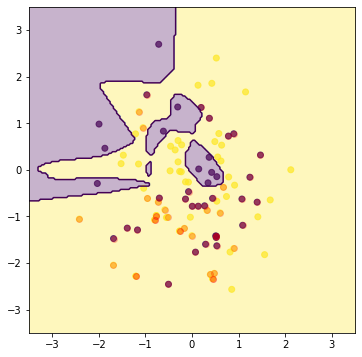

Iteration: 4
0.002


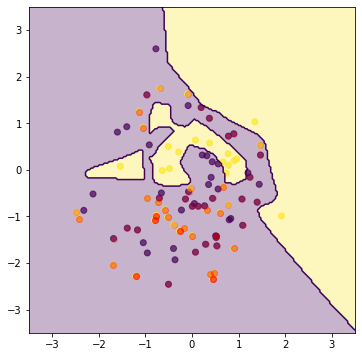

Iteration: 5
0.0016666666666666666


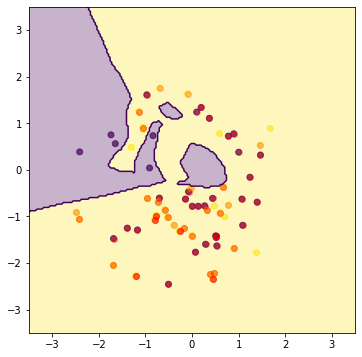

In [12]:
t = 1

while n_exploration > 0:
    
    print('Iteration: {}'.format(t))

    # Generate new points and label them
    X_new = np.random.multivariate_normal(np.zeros((d,)), np.eye(d,d), size = n_exploration)
    y_new = original.predict(X_new)
    y_new_oh_mamma = tf.one_hot(y_new, 2)
    y_new = np.argmax(y_new_oh_mamma, axis=1)
    
    # Update synthetic trainign set with new points
    X_train_ = np.vstack((X_budget, X_new))
    y_train_ = np.append(y_budget, y_new)
    
    
    # Update copy
    decay = (decay / max_iter) * t
    print(decay)
    copy_model.fit(X_train_, tf.one_hot(y_train_,2), 
                   epochs=n_epochs, batch_size=32, verbose=0,
                   callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=0)])
    
   
    # copy_model.fit(X_train_, tf.one_hot(y_train_, 2), epochs=n_epochs, batch_size=32, verbose=0)
    
    # Identify errors
    y_pred_ = np.argmax(copy_model.predict(X_train_), axis=1)
    X_errors = X_train_[y_pred_!=y_train_,:]
    y_errors = y_train_[y_pred_!=y_train_]

    n_errors.append(len(y_errors))
    
    # Add errors to the budget
    X_budget = np.vstack((X_budget, X_errors))
    y_budget = np.append(y_budget, y_errors)
    
    # Update exploration size
    n_exploration = max_exploration - len(y_budget)
    
    # Plot model
    xx,yy = np.meshgrid(np.linspace(-3.5,3.5,200),np.linspace(-3.5,3.5,200))
    viz=np.c_[xx.ravel(),yy.ravel()]

    z = np.argmax(copy_model.predict(viz), axis=1)
    
    plt.scatter(X_train_[:, 0], X_train_[:, 1], c=y_train_,  alpha=0.7)
    plt.scatter(X_budget[:, 0], X_budget[:, 1], c='red',  alpha=0.2)
   
    plt.imshow(z.reshape((200,200)), origin='lower', extent=(-3.5,3.5,-3.5,3.5),alpha=0.3, vmin=0, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)),[0.5])

    plt.gcf().set_size_inches((6,6))
    
    plt.show()
    
    # Compute copy accuracy on original test data
    acc.append(copy_model.evaluate(X_test, tf.one_hot(y_test, 2), verbose=0)[1])
    
    t += 1
    max_iter = t+1

### Minimum memory

Errors are added to the budget, revisited once and then removed. The process ends either when the budget is full or when the maximum number of iterations is reached.

Another option is setting an error threshold, such that once having reached a desired empirical fidelity error the process stops running.

In [13]:
import tensorflow as tf

# This model has been tested against the original training data
# Check the notebook network_training PyTorch-Tensorflow for reference
copy_model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(64, input_shape=(2,), activation='relu', kernel_initializer='he_normal'),
          tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),  
          tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
          tf.keras.layers.Dense(2, activation='softmax')
        ])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

copy_model.compile(optimizer=opt, 
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [14]:
d = 2 # dimensions
max_exploration = 100 # budget size
n_epochs = 1000 # number of epochs for each training step
n_exploration = max_exploration # exploration size
max_iter = 15 # max number of iterations
t_memory = 1 # max iterations errors are kept in budget

# Create empty budget of points and timestamps
X_budget = np.empty((0, d))
y_budget = np.empty((0), dtype=int)
t_budget = np.empty((0), dtype=int)

# One-hot test data points
y_test_oh_mamma = tf.one_hot(y_test, 2)
y_test = np.argmax(y_test_oh_mamma, axis=1)

# Initialize error array
acc = []
n_errors = []

Iteration: 1


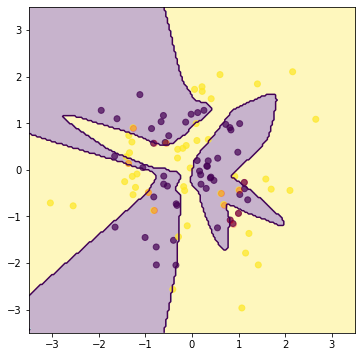

Iteration: 2


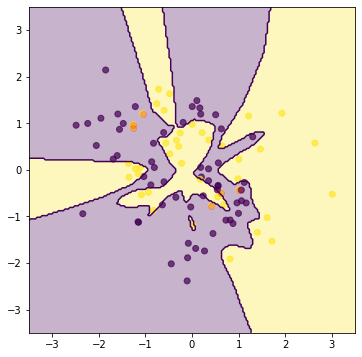

Iteration: 3


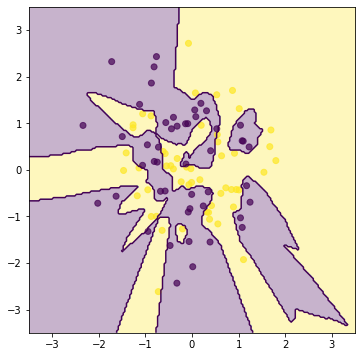

Iteration: 4


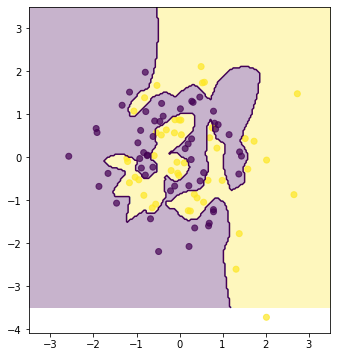

Iteration: 5


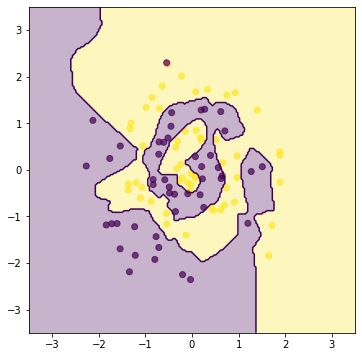

Iteration: 6


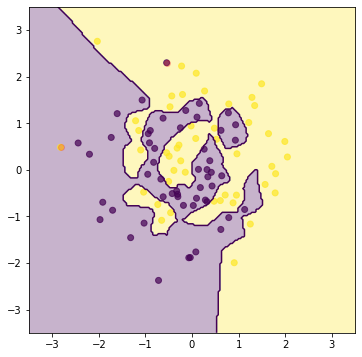

Iteration: 7


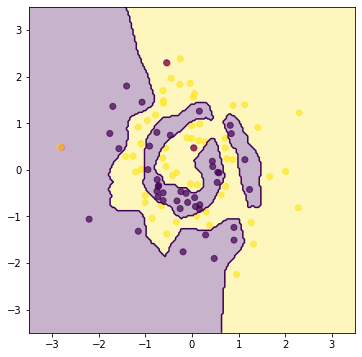

Iteration: 8


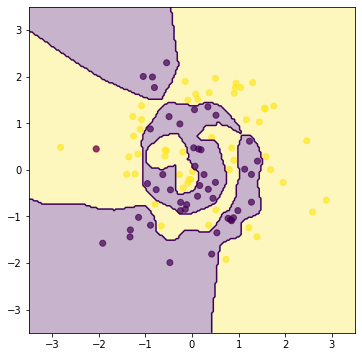

Iteration: 9


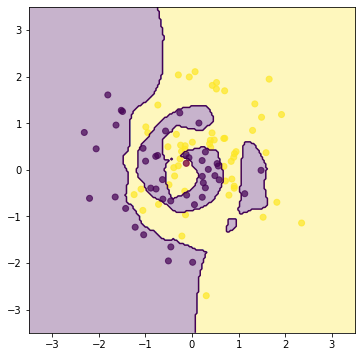

Iteration: 10


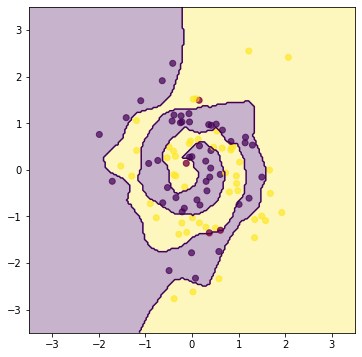

Iteration: 11


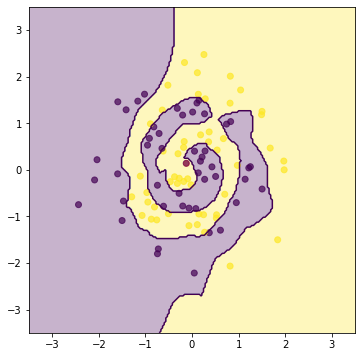

Iteration: 12


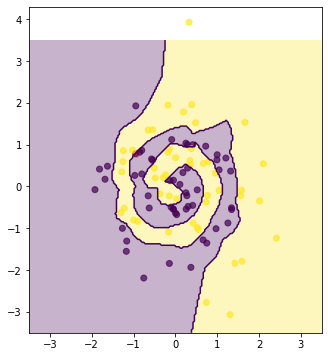

Iteration: 13


KeyboardInterrupt: 

In [15]:
t = 1

while n_exploration > 0:
    
    print('Iteration: {}'.format(t))

    # Generate new points and label them
    X_new = np.random.multivariate_normal(np.zeros((d,)), np.eye(d,d), size = n_exploration)
    y_new = original.predict(X_new)
    y_new_oh_mamma = tf.one_hot(y_new, 2)
    y_new = np.argmax(y_new_oh_mamma, axis=1)
    
    # Update synthetic trainign set with new points
    X_train_ = np.vstack((X_budget, X_new))
    y_train_ = np.append(y_budget, y_new)
    
    # Update copy
    copy_model.fit(X_train_, tf.one_hot(y_train_,2), epochs=n_epochs, batch_size=32, verbose=0)
    
    # Identify errors
    y_pred_ = np.argmax(copy_model.predict(X_train_), axis=1)
    X_errors = X_train_[y_pred_!=y_train_,:]
    y_errors = y_train_[y_pred_!=y_train_]

    n_errors.append(len(y_errors))
    
    # Add errors to the budget
    X_budget = np.vstack((X_budget, X_errors))
    y_budget = np.append(y_budget, y_errors)
    t_budget = np.append(t_budget, t*np.ones(len(y_errors)))
    
    # Remove old errors from budget
    X_budget = X_budget[(t-t_budget)<t_memory]
    y_budget = y_budget[(t-t_budget)<t_memory]
    t_budget = t_budget[(t-t_budget)<t_memory]
    
    # Update exploration size
    n_exploration = max_exploration - len(y_budget)
    
    # Plot model
    xx,yy = np.meshgrid(np.linspace(-3.5,3.5,200),np.linspace(-3.5,3.5,200))
    viz=np.c_[xx.ravel(),yy.ravel()]

    z = np.argmax(copy_model.predict(viz), axis=1)
    
    plt.scatter(X_train_[:, 0], X_train_[:, 1], c=y_train_,  alpha=0.7)
    plt.scatter(X_budget[:, 0], X_budget[:, 1], c='red',  alpha=0.2)
   
    plt.imshow(z.reshape((200,200)), origin='lower', extent=(-3.5,3.5,-3.5,3.5),alpha=0.3, vmin=0, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)),[0.5])

    plt.gcf().set_size_inches((6,6))
    
    plt.show()
    
    # Compute copy accuracy on original test data
    acc.append(copy_model.evaluate(X_test,  tf.one_hot(y_test, 2), verbose=0)[1])
    
    t += 1

### Optimal memory policies

Balance between exploration and exploitation. At the beginning of the process, exploration is more desirable, because we want to gain information about how the original model hbehaves throughout the space. Erros are only kept for a few (or one) iterations. As we progress, we want to focus on the areas of the space where performance is lower, i.e. the hard to learn regions. Hence, we increase the memory budget to ensure the model focuss on those areas. A good choice of memory function could be, for example, a sigmoid.

The process stops when the budget is full or when the copy model reaches a desired error threshold.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))